<a href="https://colab.research.google.com/github/u-masao/vector-search-tutorial-for-japanese/blob/main/Session02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 日本語のためのベクトル検索ハンズオン：Session 2

## はじめに

『日本語のためのベクトル検索ハンズオン』の Session02 では、Hugging Face に登録されている埋め込みモデルを利用してシンプルなベクトル検索を実装します。

埋め込みモデルをトークナイザーとモデルに分解して入出力を確認することで、トークナイザーの役割とモデルの役割を確認します。

## 埋め込みモデルの利用


### モデル

![HuggingFace](https://huggingface.co/datasets/huggingface/brand-assets/resolve/main/hf-logo-with-title.png)

SentenceTransformers パッケージを利用して HuggingFace で公開されている埋め込みモデルを利用します。

- 日本語対応の Sentence Similarity モデルの一覧(日々更新される)

    - [モデル検索ページ](https://huggingface.co/models?pipeline_tag=sentence-similarity&language=ja&sort=trending)

In [1]:
!pip install -q sentence-transformers japanize_matplotlib

In [2]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
import torch.nn.functional as F
from torch import Tensor
from transformers import AutoTokenizer, AutoModel

In [3]:
# テキストを定義
item_df = pd.DataFrame([
    {'id':10, 'theme':'自転と公転', 'text':'地球は自転しており、24時間で一回転します。これにより日夜が発生します。また、地球は太陽の周りを365日で一周する公転もしており、これが季節の変化を引き起こします。',},
    {'id':11, 'theme':'自転と公転', 'text':'地球の自転により、一日の長さが決まり、夜と昼が交互にやってきます。公転は太陽の周りの一周で、約一年かかり、四季の移り変わりの原因となります。',},
    {'id':12, 'theme':'自転と公転', 'text':'自転とは地球が自軸を中心に一日で一回転することで、日の出と日の入りが生じます。公転は地球が太陽の周囲を約365日かけて一周し、季節の変動をもたらします。',},
    {'id':13, 'theme':'自転と公転', 'text':'地球はその軸を中心に自転し、それが24時間周期の昼夜を生み出しています。一方で、地球は太陽の周りを公転し、この動きが年間を通じて気候の変化を引き起こす季節変動を生成します。',},
    {'id':20, 'theme':'メトロノームの効能', 'text':'メトロノームを使うことでリズム感が養われ、一定のテンポで正確に演奏する練習ができます。これは音楽の演奏技術向上に非常に役立ちます。',},
    {'id':21, 'theme':'メトロノームの効能', 'text':'メトロノームを使用することで、音楽演奏時のテンポの維持が容易になります。これにより、演奏の一貫性と精度が向上します。',},
    {'id':22, 'theme':'メトロノームの効能', 'text':'メトロノームは演奏者がリズムを厳密に守ることを助け、特にグループでの演奏において同期を取るのに役立ちます。このツールは練習時の集中力も高めます。',},
    {'id':23, 'theme':'メトロノームの効能', 'text':'メトロノームを利用すると、演奏中のテンポを客観的に把握でき、リズムのぶれを修正するのに有効です。これにより、よりプロフェッショナルな演奏技術を身につけることができます。',},
]).set_index('id')

display(item_df)

,theme,text
id,,
10,自転と公転,地球は自転しており、24時間で一回転します。これにより日夜が発生します。また、地球は太陽の周...
11,自転と公転,地球の自転により、一日の長さが決まり、夜と昼が交互にやってきます。公転は太陽の周りの一周で、...
12,自転と公転,自転とは地球が自軸を中心に一日で一回転することで、日の出と日の入りが生じます。公転は地球が太...
13,自転と公転,地球はその軸を中心に自転し、それが24時間周期の昼夜を生み出しています。一方で、地球は太陽の...
20,メトロノームの効能,メトロノームを使うことでリズム感が養われ、一定のテンポで正確に演奏する練習ができます。これは...
21,メトロノームの効能,メトロノームを使用することで、音楽演奏時のテンポの維持が容易になります。これにより、演奏の一...
22,メトロノームの効能,メトロノームは演奏者がリズムを厳密に守ることを助け、特にグループでの演奏において同期を取るの...
23,メトロノームの効能,メトロノームを利用すると、演奏中のテンポを客観的に把握でき、リズムのぶれを修正するのに有効で...


In [4]:
# モデル名を定義(HuggingFaceのモデル名)
#   https://huggingface.co/intfloat/multilingual-e5-small
model_name = "intfloat/multilingual-e5-small"

# 埋め込みモデルを初期化
# モデルを Hugging Face からダウンロードしてロードするため初回は少し時間がかかります
model = SentenceTransformer(model_name)

# 埋め込みベクトルを取得
embeddings = model.encode(item_df['text'].values)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
# 返り値の型
print(type(embeddings))

<class 'numpy.ndarray'>


In [6]:
# 形状
print(embeddings.shape)

(8, 384)


In [7]:
# ベクトルの大きさ
print(np.linalg.norm(embeddings[0].tolist(), ord=2))

0.99999998427664


In [8]:
# ベクトルの数値
display(embeddings[0])

array([ 0.07265533, -0.02737279, -0.02342032, -0.07276566,  0.11036015,
       -0.0119391 , -0.01391273,  0.04546628,  0.10458223,  0.01869721,
        0.0144851 , -0.02732359,  0.04394547,  0.02587822, -0.04370999,
        0.0263737 ,  0.05032514, -0.06193559,  0.01469676, -0.03283325,
        0.01529458,  0.04244423, -0.07038571,  0.07879799,  0.0586671 ,
        0.06745208, -0.00624266,  0.07424284,  0.04060534, -0.07351615,
       -0.03221299, -0.06772496,  0.02450223, -0.05059789,  0.05979783,
        0.02648341, -0.01048144, -0.06466465,  0.06472722, -0.07025819,
        0.00574615,  0.00927107,  0.0346462 ,  0.03380042,  0.0218608 ,
        0.1355815 , -0.05699701,  0.04978235, -0.04721194, -0.01302735,
       -0.03295247,  0.02687644,  0.03764228,  0.04538498,  0.02094763,
       -0.08717156, -0.0390455 , -0.07496147, -0.07391667,  0.09129124,
        0.08788916,  0.02345508,  0.02238471,  0.05904458,  0.10307614,
        0.05671706,  0.01734488,  0.0543476 ,  0.00632273, -0.05

In [9]:
# コサインを計算する関数を定義
def cosine(vec_a, vec_b):
    l2norm_a = np.linalg.norm(vec_a, ord=2)
    l2norm_b = np.linalg.norm(vec_b, ord=2)
    return (vec_a @ vec_b) / (l2norm_a * l2norm_b)

# 各文書について総当りでコサインを計算
similarity_matrix = {}
for x in range(len(item_df)):
    row = {}
    for y in range(len(item_df)):
        # 2 つの埋め込みベクトルに対してコサインを計算
        row[item_df.iloc[y].name]=cosine(embeddings[x], embeddings[y])
    similarity_matrix[item_df.iloc[x].name] = row
similarity_df =pd.DataFrame(similarity_matrix)

# 表示
display(similarity_df)

,10,11,12,13,20,21,22,23
10,1.000000,0.958078,0.950788,0.960311,0.795296,0.785270,0.773369,0.782573
11,0.958078,1.000000,0.961488,0.939677,0.802750,0.792080,0.780250,0.786090
12,0.950788,0.961488,1.000000,0.937830,0.777413,0.769831,0.755127,0.760393
13,0.960311,0.939677,0.937830,1.000000,0.797479,0.788939,0.776972,0.785247
20,0.795296,0.802750,0.777413,0.797479,1.000000,0.979591,0.962964,0.975847
21,0.785270,0.792080,0.769831,0.788939,0.979591,1.000000,0.955072,0.969912
22,0.773369,0.780250,0.755127,0.776972,0.962964,0.955072,1.000000,0.946316
23,0.782573,0.786090,0.760393,0.785247,0.975847,0.969912,0.946316,1.000000


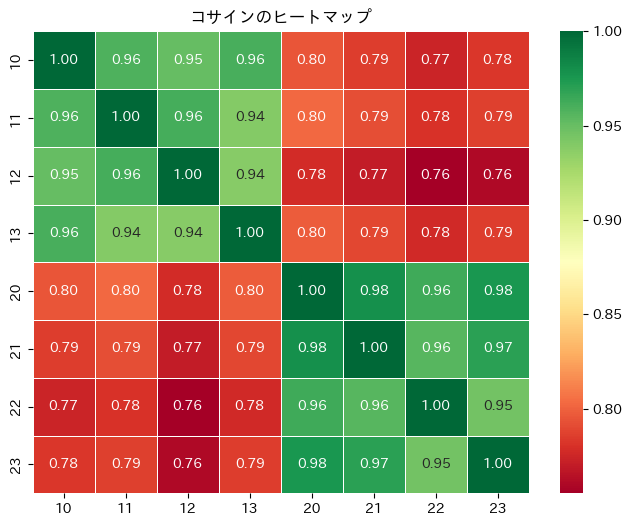

In [10]:
# コサインをヒートマップで表示
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(similarity_df, annot=True, cmap='RdYlGn', linewidths=.5, fmt=".2f", ax=ax)
ax.set_title("コサインのヒートマップ")
fig.show()

## 埋め込みモデルの動き

文字列を埋め込みベクトルに変換する際は、2 つの機構が働きます。

1. トークナイザー
2. 埋め込みモデル

トークナイザーは、内蔵する語彙(ボキャブラリ)等を利用して自然言語をトークンに分割します。トークンに割り当てられた id を利用して自然言語を整数の数値列に変換します。このセッションで利用する埋め込みモデル「Multilingual-E5」は、SentencePiese というトークナイザーを利用しています。MeCab 等の形態素解析処理と異なり、バイトレベルで文字を分割してからトークンを学習するため、辞書のメンテナンスは不要です。

埋め込みモデルは、トークン列に対して埋め込みベクトルを計算します。Multiilngual-E5 は、「似ている文章」の埋め込みベクトル同士のコサインが大きくなるように学習されています。


### 参考

- トークナイザーの概要
  - https://huggingface.co/docs/transformers/ja/tokenizer_summary

- Multilingual-E5-small のモデルカード
  - https://huggingface.co/intfloat/multilingual-e5-small

- 論文: Text Embeddings by Weakly-Supervised Contrastive Pre-training
  - https://ar5iv.labs.arxiv.org/html/2212.03533v1


In [11]:
# 最終隠れ層に対するアベレージプーリング関数を定義
def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]


# トークナイザーの初期化
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 埋め込みモデルの初期化
embedding_model = AutoModel.from_pretrained(model_name)

In [12]:
# 埋め込み対象文字列を定義
texts = [
    '吾輩は猫である。名前はまだ無い。',
    '私は生まれたばかりの猫です。まだ名前を決めていないのです。',
    '線形代数学と幾何学と位相空間論を学ぶ学生さんの素敵な日常',
    'ベクトルデータベースは、深層学習アーキテクチャなどの不透明な機械学習モデルから派生した抽象データ表現を操作するための比較的新しい方法です。',
]

In [13]:
# トークナイズ
batch_dict = tokenizer(texts, max_length=512, padding=True, truncation=True, return_tensors='pt')

In [14]:
# 埋め込みモデルで処理
outputs = embedding_model(**batch_dict)

In [15]:
# アベレージプーリングで最終隠れ層をサマライズ
item_embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

In [16]:
from torch.nn import CosineSimilarity

# コサイン計算機をインスタンス化
cos = CosineSimilarity(dim=0)

# 各センテンスを総当りでコサインを計算
scores = {}
for i in range(len(texts)):
    row = {}
    for j in range(len(texts)):
        row[j] = cos(item_embeddings[i], item_embeddings[j]).item()
    scores[i] = row
score_df = pd.DataFrame(scores)

# 結果を表示
display(score_df)

,0,1,2,3
0,1.000000,0.886615,0.794468,0.746712
1,0.886615,1.000000,0.814253,0.796628
2,0.794468,0.814253,1.000000,0.797136
3,0.746712,0.796628,0.797136,1.000000


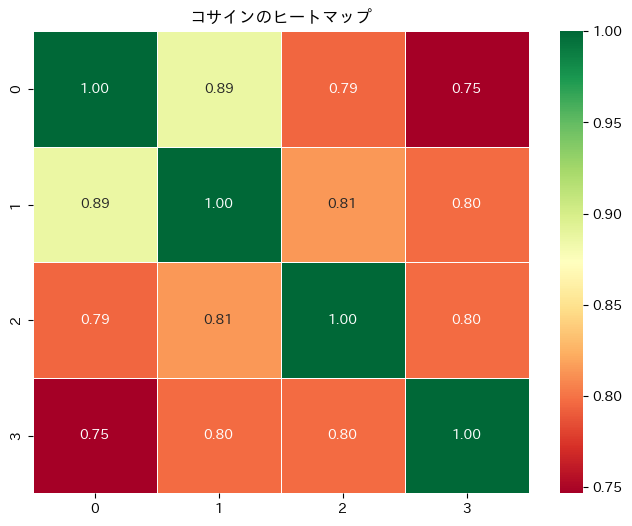

In [17]:
# ヒートマップを表示
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(score_df, annot=True, cmap='RdYlGn', linewidths=.5, fmt=".2f", ax=ax)
ax.set_title("コサインのヒートマップ")
fig.show()

## 埋め込みベクトルについて

In [18]:
print("埋め込みベクトルの形:", item_embeddings.shape)
print("ベクトルの長さ:", np.linalg.norm(item_embeddings.detach().numpy(), ord=2, axis=1))

埋め込みベクトルの形: torch.Size([4, 384])
ベクトルの長さ: [4.6399198 4.917329  4.6650753 4.527279 ]


### トークナイザーについて

In [19]:
# 型を表示
type(tokenizer)

transformers.models.xlm_roberta.tokenization_xlm_roberta_fast.XLMRobertaTokenizerFast

In [20]:
# トークナイザーの出力を確認
# 'input_ids' がトークン列
# 'attension_mask' がマスクビット
batch_dict

{'input_ids': tensor([[     0,      6, 166400, 109055,    342,  35076,   8929,     30,  65610,
         150245, 125151,     30,      2,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1],
        [     0,  65579, 205146,  52373,    154,  35076,   1453,     30,  33798,
          65610,    251,  78462,  88914,  12079,     30,      2,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1],
        [     0,      6,   5051,   9378,   5260,  78791,    610,  15818,   4931,
           4058,    610,   3803,   4791,  20534,  26700,    251, 166502,   7252,
          35275, 127973,  34413,      2,      1,      1,      1,      1,    

In [21]:
# 形状
batch_dict['input_ids'].shape

torch.Size([4, 41])

In [22]:
# 最初のトークン列の値
batch_dict['input_ids'][0]

tensor([     0,      6, 166400, 109055,    342,  35076,   8929,     30,  65610,
        150245, 125151,     30,      2,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1])

In [23]:
# 3個めのトークンをデコードして表示
print(tokenizer.decode(batch_dict['input_ids'][0][2]))

吾


In [24]:
# トークンをデコード
# <pad> が沢山入る
tokenizer.decode(batch_dict['input_ids'][0])

'<s> 吾輩は猫である。名前はまだ無い。</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

In [25]:
# 各トークンを1行で表示する
# 単語レベルよりも細かく分割されているのが確認できる(アー, キ, テ, ク, チャ)
for token in batch_dict['input_ids'][3]:
    if token != 1:
        print(f"{tokenizer.decode(token)}\t{token}")

<s>	0
	6
ベ	43339
ク	4758
トル	128346
データ	45465
ベース	146509
は	342
、	37
深	6728
層	14967
学習	107528
アー	135745
キ	14323
テ	19827
ク	4758
チャ	58440
などの	18009
不	562
透明	56896
な	1308
機械	50866
学習	107528
モデル	91191
から	1309
派	10356
生	2026
した	2419
抽象	198286
データ	45465
表現	23014
を	251
操作	13160
するための	124481
比較	9455
的	43
新しい	38851
方法	5796
です	1453
。	30
</s>	2


In [26]:
# 語彙を取得
vocab=tokenizer.get_vocab()

print(type(vocab))
print(len(vocab))

start=226_000
display(sorted(vocab)[start:start+100])

<class 'dict'>
250002


['いること',
 'いると',
 'いるの',
 'いるのか',
 'いるので',
 'いれば',
 'いろいろ',
 'いろいろな',
 'いろんな',
 'いわゆる',
 'ぅ',
 'う',
 'うえで',
 'うこと',
 'うち',
 'うちに',
 'うちの',
 'うまく',
 'うれしい',
 'ぇ',
 'え',
 'えた',
 'えて',
 'えない',
 'えば',
 'えます',
 'える',
 'ぉ',
 'お',
 'おい',
 'おいしい',
 'おいて',
 'おう',
 'おか',
 'おかげで',
 'おき',
 'おきたい',
 'おきましょう',
 'おしゃれ',
 'おすすめ',
 'おすすめです',
 'おすすめの',
 'おそらく',
 'おっしゃ',
 'およそ',
 'および',
 'おり',
 'おります',
 'お世話',
 'お互い',
 'お仕事',
 'お休み',
 'お会い',
 'お伝え',
 'お使い',
 'お勧め',
 'お友達',
 'お問い合わせ',
 'お問い合わせください',
 'お問合せ',
 'お土産',
 'お子さん',
 'お子様',
 'お客さま',
 'お客さん',
 'お客様',
 'お客様に',
 'お客様の',
 'お届け',
 'お店',
 'お弁当',
 'お待ち',
 'お待ちしております',
 'お得',
 'お得な',
 'お悩み',
 'お手伝い',
 'お支払い',
 'お楽しみ',
 'お母さん',
 'お気に入り',
 'お気軽に',
 'お申し込み',
 'お申込み',
 'お知らせ',
 'お祝い',
 'お肌',
 'お腹',
 'お茶',
 'お菓子',
 'お試し',
 'お話',
 'お越し',
 'お送り',
 'お酒',
 'お金',
 'お金を',
 'お電話',
 'お願い',
 'お願いいたします']

### 埋め込みモデルについて

In [27]:
# 型を表示
type(embedding_model)

transformers.models.bert.modeling_bert.BertModel

In [28]:
# 埋め込みモデルの出力
outputs

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.3479, -0.0181, -0.0715,  ...,  0.2091,  0.2447,  0.0107],
         [ 0.3096,  0.0174,  0.1258,  ..., -0.0620,  0.6459,  0.2021],
         [ 0.3759, -0.0167, -0.1307,  ...,  0.2724,  0.4138,  0.1373],
         ...,
         [ 0.4231, -0.0478, -0.0198,  ...,  0.2971,  0.4338,  0.0908],
         [ 0.4239, -0.0471, -0.0084,  ...,  0.3011,  0.4194,  0.0868],
         [ 0.4208, -0.0381,  0.0034,  ...,  0.2956,  0.4054,  0.0833]],

        [[ 0.1932, -0.0650, -0.0761,  ...,  0.2749,  0.0963,  0.0708],
         [ 0.1157, -0.1209,  0.0304,  ...,  0.3498,  0.2150,  0.3116],
         [ 0.0020, -0.0326,  0.0157,  ...,  0.4358,  0.1509,  0.2240],
         ...,
         [ 0.1853, -0.0929, -0.1003,  ...,  0.3886,  0.0729,  0.1668],
         [ 0.1899, -0.0822, -0.0800,  ...,  0.3870,  0.0614,  0.1527],
         [ 0.1806, -0.0829, -0.0610,  ...,  0.3936,  0.0312,  0.1479]],

        [[ 0.2402,  0.0094, -0.1539,  ...,  0.0759,  

In [29]:
# メソッド等を表示
[ x for x in dir(outputs) if not str(x).startswith("__")]

['attentions',
 'clear',
 'copy',
 'cross_attentions',
 'fromkeys',
 'get',
 'hidden_states',
 'items',
 'keys',
 'last_hidden_state',
 'move_to_end',
 'past_key_values',
 'pooler_output',
 'pop',
 'popitem',
 'setdefault',
 'to_tuple',
 'update',
 'values']

In [30]:
# モデル概要を表示
embedding_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(250037, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [31]:
# モデルのメソッド等を表示
[ x for x in dir(embedding_model) if not str(x).startswith("__")]

['T_destination',
 '_apply',
 '_assisted_decoding',
 '_auto_class',
 '_autoset_attn_implementation',
 '_backward_compatibility_gradient_checkpointing',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_beam_sample',
 '_beam_search',
 '_buffers',
 '_call_impl',
 '_check_and_enable_flash_attn_2',
 '_check_and_enable_sdpa',
 '_compiled_call_impl',
 '_constrained_beam_search',
 '_contrastive_search',
 '_convert_head_mask_to_5d',
 '_copy_lm_head_original_to_resized',
 '_create_repo',
 '_dispatch_accelerate_model',
 '_expand_inputs_for_generation',
 '_extract_past_from_model_output',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_from_config',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_candidate_generator',
 '_get_decoder_start_token_id',
 '_get_files_timestamps',
 '_get_logits_processor',
 '_get_logits_warper',
 '_get_name',
 '_get_no_split_modules',
 '_get_resized_embeddings',
 '_g